In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initial Exploration and Preparation

## Merge all training data files

In [2]:
# merge all files in the folder "data/datasets_seletected" into one excel file

import pandas as pd
import os
import glob

df_merged_file = pd.DataFrame()

# cycle through all files in the folder "data/datasets_seletected"
path = r'data/datasets_seletected'
all_files = glob.glob(os.path.join(path, "*.xlsx"))
for file in all_files:
    # append all files into one dataframe
    df = pd.read_excel(file)
    # concat all files into one dataframe
    df_merged_file = pd.concat([df_merged_file, df], ignore_index=True)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310

## Initial preprocessing

In [3]:
df_triage_initial = df_merged_file.copy()

# remove all empty rows
df_triage_initial = df_triage_initial.dropna(how='all')

# reset index
df_triage_initial = df_triage_initial.reset_index(drop=True)

# we do not need all the doctors evaluations
df_triage_initial = df_triage_initial.drop(df_triage_initial.columns[df_triage_initial.columns.get_loc('Exacerbation (Y/N)') + 1:], axis=1)
# drop Vitals Severity (1-5)
df_triage_initial = df_triage_initial.drop(columns=['Vitals Severity (1-5)'], axis=1)
# convert all values where it say 'Unknown' to NaN
df_triage_initial = df_triage_initial.replace('Unknown', np.nan)
# convert all strings that contain the value 'n' and 'n' only to 0
df_triage_initial = df_triage_initial.replace('n', 0)

# turn Male into 1 and Female into 0
df_triage_initial = df_triage_initial.replace('Male', 0)
df_triage_initial = df_triage_initial.replace('Female', 1)

# convert height from Height(ft) and Height(in) to Height(cm)
df_triage_initial['Height(cm)'] = df_triage_initial['Height(ft)'] * 30.48 + df_triage_initial['Height(in)'] * 2.54
# drop Height(ft) and Height(in)
df_triage_initial = df_triage_initial.drop(columns=['Height(ft)', 'Height(in)'], axis=1)

# convert weight from Weight(lbs) to Weight(kg)
df_triage_initial['Weight(kg)'] = df_triage_initial['Weight (lb)'] * 0.45359237
# drop Weight(lbs)
df_triage_initial = df_triage_initial.drop(columns=['Weight (lb)'], axis=1)

# recalculate BMI for metric system
df_triage_initial['BMI'] = df_triage_initial['Weight(kg)'] / (df_triage_initial['Height(cm)'] / 100) ** 2

# convert temperature from Temperature(F) to Temperature(C)
df_triage_initial['Current Temperature'] = (df_triage_initial['Current Temperature'] - 32) * 5 / 9


risk_factors = ()
# add all unique values in columns Risk Factor 1-4 to risk_factors, make sure there are no duplicates
for i in range(1, 5):
    risk_factors += tuple(df_triage_initial['Risk Factor ' + str(i)].unique())
risk_factors = tuple(set(risk_factors))
# remove NaN from risk_factors
risk_factors = tuple(filter(lambda x: x == x, risk_factors))
# create a column for each risk factor in risk_factors
for risk_factor in risk_factors:
    df_triage_initial[risk_factor] = 0
# set all values in the columns to 1 if the risk factor is present
for i in range(1, 5):
    for risk_factor in risk_factors:
        df_triage_initial.loc[df_triage_initial['Risk Factor ' + str(i)] == risk_factor, risk_factor] = 1
# drop Risk Factor 1-4
df_triage_initial = df_triage_initial.drop(columns=['Risk Factor ' + str(i) for i in range(1, 5)], axis=1)

medications = ()
# split each value in 'Current Medication' at + and add the medication to the tuple if it is not already in there
for medication in df_triage_initial['Current Medication']:
    # if the value is not empty
    if medication == medication:
        # split the value at + and add the medication to the tuple if it is not already in there
        for med in str(medication).split('+'):
            if med not in medications:
                medications += (med,)

print(medications)

medications = ['Pill for Controlling Exacerbations', 'Prescribed Inhaler', 'escue Inhaler',  'Daily Controller'] 

# TODO need to make Rescue Inhaler as Needed and rescue Inhaler As Needed. the same

# create a column for each medication in medications
for medication in medications:
    df_triage_initial[medication] = 0
# set all values in the columns to 1 if the medication is present
for medication in medications:
    df_triage_initial.loc[df_triage_initial['Current Medication'].str.contains(medication, na=False), medication] = 1
# drop Current Medication
df_triage_initial = df_triage_initial.drop(columns=['Current Medication'], axis=1)

# turn Baseline Dyspnea (MMRC) into the number that the value contains
df_triage_initial['Baseline Dyspnea (MMRC)'] = df_triage_initial['Baseline Dyspnea (MMRC)'].str.extract('(\d+)')
# turn COPD Gold Stage into the number that the value contains
df_triage_initial['COPD Gold Stage'] = df_triage_initial['COPD Gold Stage'].str.extract('(\d+)').astype('float64')
# turn Recent Worsening in Symptoms? into categorical values for each unique values
df_triage_initial['Recent Worsening in Symptoms?'] = df_triage_initial['Recent Worsening in Symptoms?'].astype('category').cat.codes
# turn % Controller Medication Taken Over Last Week into categorical values for each unique values
df_triage_initial['% Controller Medication Taken Over Last Week'] = df_triage_initial['% Controller Medication Taken Over Last Week'].astype('category').cat.codes
# turn Short of Breath? into categorical values for each unique values
df_triage_initial['Short of Breath?'] = df_triage_initial['Short of Breath?'].astype('category').cat.codes
# turn Cough? into categorical values for each unique values
df_triage_initial['Cough?'] = df_triage_initial['Cough?'].astype('category').cat.codes
# turn Sputum? into categorical values for each unique values
df_triage_initial['Sputum?'] = df_triage_initial['Sputum?'].astype('category').cat.codes
# turn Wheezing? into categorical values for each unique values
df_triage_initial['Wheezing?'] = df_triage_initial['Wheezing?'].astype('category').cat.codes

# turn Current Dyspnea (MMRC) into the number that the value contains
df_triage_initial['Current Dyspnea (MMRC)'] = df_triage_initial['Current Dyspnea (MMRC)'].str.extract('(\d+)')

# turn all values that contain 'No' into 0 and all values that contain 'Yes' into 1
df_triage_initial = df_triage_initial.replace('No', 0)
df_triage_initial = df_triage_initial.replace('Yes', 1)
df_triage_initial = df_triage_initial.replace('Y', 1)
df_triage_initial = df_triage_initial.replace('y', 0)
df_triage_initial = df_triage_initial.replace('N', 0)

# save the file
df_triage_initial.to_csv('data/triage_preprocessed.csv', index=False, sep=";")

('Pill for Controlling Exacerbations ', ' Prescribed Inhaler ', ' Rescue Inhaler As Needed', 'Prescribed Inhaler (Azithromycin or Roflumilast) ', ' rescue Inhaler As Needed.', 'Rescue Inhaler Or Nebulizer As Needed For Breathing', 'Daily Controller Inhaler ', 'Pill for Controlling Exacerbations (Azithromycin or Roflumilast) ', ' Daily Controller Inhaler ')


## Heuristic Feature Selection

In [4]:
# we only want to keep the baseline values and not the current values
df_triage_selected = df_triage_initial.copy()

df_triage_selected = df_triage_selected.drop(columns=['Unnamed: 0', 'Unnamed: 36','Current Dyspnea (MMRC)', 'Current Heart Rate', 'Current Pulse Ox', 'Current FEV1 (% Predicted)', 'Profile Severity (1-5)', 'Symptom Severity (1-5)', 'risk factor'], axis=1)

print(df_triage_selected.columns)


Index(['Gender', 'Age', 'BMI', 'Baseline Dyspnea (MMRC)', 'COPD Gold Stage',
       'Baseline FEV1', 'Baseline Heart Rate', 'Baseline Pulse Ox',
       'Recent Worsening in Symptoms?',
       '% Controller Medication Taken Over Last Week', 'Short of Breath?',
       'Cough?', 'Wheezing?', 'Sputum?', 'Infection?',
       'Respiratory Symptoms Wake You Up At Night More Than Usual?',
       'Baseline Heart Rate.1', 'Baseline Pulse Ox.1',
       'Baseline FEV1 (% Predicted)', 'Current Temperature',
       'Exacerbation (Y/N)', 'Height(cm)', 'Weight(kg)', 'Acid Reflux',
       'Diabetes', 'Coronary Artery Disease', 'Long Term Oxygen User',
       '2 or More Exacerbations In Last Year', 'Congestive Heart Failure',
       'Hospitalized for COPD in Last Year', 'Pulmonary Hypertension',
       'Needs Help Performing Daily Activities', 'Anemia', 'Asthma',
       'Chronic Kidney Disease', 'Visited ICU for COPD in Last Year',
       'Lives Alone', 'Smoker', 'High Blood Pressure',
       'Pill for 

## Rename variables

In [11]:
rename_dict = {
    'Gender': 'Gender, Male',
    'Age': 'Age',
    'BMI': 'BMI',
    'Baseline Dyspnea (MMRC)': 'MMRC',
    'COPD Gold Stage': 'GOLD',
    'Baseline FEV1': 'FEV1',
    'Baseline Heart Rate': 'Heartrate',
    'Baseline Pulse Ox': 'Ox Saturation',
    'Recent Worsening in Symptoms?': 'Worse Symptoms',
    '% Controller Medication Taken Over Last Week': '% Controller Taken',
    'Short of Breath?': 'Worse dyspnea',
    'Cough?': 'Worse cough',
    'Wheezing?': 'Wheezing',
    'Sputum?': 'Increase in sputum',
    'Infection?': 'Infection',
    'Respiratory Symptoms Wake You Up At Night More Than Usual?': 'Night Symptoms',
    'Baseline Heart Rate.1': 'Heartrate 2',
    'Baseline Pulse Ox.1': 'Ox Saturation 2',
    'Baseline FEV1 (% Predicted)': 'FEV1 %',
    'Exacerbation (Y/N)': 'Exacerbation',
    'Height(cm)': 'Height',
    'Weight(kg)': 'Weight',
    'Long Term Oxygen User': 'Oxygen Therapy',
    'Diabetes': 'Diabetes',
    'High Blood Pressure': 'Hypertension',
    'Pulmonary Hypertension': 'Pulmonary Hypertension',
    'Coronary Artery Disease': 'Coronary Artery Disease',
    '2 or More Exacerbations In Last Year': '2+ Exa. last year',
    'Congestive Heart Failure': 'Congestive Heart Failure',
    'Visited ICU for COPD in Last Year': 'ICU last year',
    'Hospitalized for COPD in Last Year': 'Hospitalized last year',
    'Chronic Kidney Disease': 'Kidney disease',
    'Smoker': 'Smoker',
    'Lives Alone': 'Lives Alone',
    'Anemia': 'Anemia',
    'Acid Reflux': 'Acid Reflux',
    'Asthma': 'Asthma',
    'Needs Help Performing Daily Activities': 'Help Daily Activities',
    'Pill for Controlling Exacerbations': 'Pill to control Exa.',
    'escue Inhaler': 'Rescue Inhaler',
}

df_triage_renamed = df_triage_selected.rename(columns=rename_dict)

print(sorted(df_triage_renamed.columns))

['% Controller Taken', '2+ Exa. last year', 'Acid Reflux', 'Age', 'Anemia', 'Asthma', 'BMI', 'Congestive Heart Failure', 'Coronary Artery Disease', 'Current Temperature', 'Daily Controller', 'Diabetes', 'Exacerbation', 'FEV1', 'FEV1 %', 'GOLD', 'Gender, Male', 'Heartrate', 'Heartrate 2', 'Height', 'Help Daily Activities', 'Hospitalized last year', 'Hypertension', 'ICU last year', 'Increase in sputum', 'Infection', 'Kidney disease', 'Lives Alone', 'MMRC', 'Night Symptoms', 'Ox Saturation', 'Ox Saturation 2', 'Oxygen Therapy', 'Pill to control Exa.', 'Prescribed Inhaler', 'Pulmonary Hypertension', 'Rescue Inhaler', 'Smoker', 'Weight', 'Wheezing', 'Worse Symptoms', 'Worse cough', 'Worse dyspnea']


## Deal with similar variables

In [12]:
from sklearn.metrics import confusion_matrix

df_triage_similars = df_triage_renamed.copy()


# drop one oxygen saturation column as they are 100% the same
df_triage_similars = df_triage_similars.drop(['Ox Saturation 2'], axis=1)
# drop one heart rate column as they are 100% the same
df_triage_similars = df_triage_similars.drop(['Heartrate 2'], axis=1)

# merge prescribed inhaler and daily controller using logical OR operation
df_triage_similars['Daily Inhaler'] = df_triage_similars['Prescribed Inhaler'] | df_triage_similars['Daily Controller']
df_triage_similars = df_triage_similars.drop(['Prescribed Inhaler'], axis=1)
df_triage_similars = df_triage_similars.drop(['Daily Controller'], axis=1)



## Export values

In [13]:
# export df_triage_similars to csv. Use comma as decimal separator and semicolon as separator
print(df_triage_similars.columns)
df_triage_similars.to_csv('data/triage_initial_preprocessed.csv', index=False, sep=';', encoding='utf-8', decimal=',')

# print missing values per variable
print(df_triage_similars.isnull().sum())

Index(['Gender, Male', 'Age', 'BMI', 'MMRC', 'GOLD', 'FEV1', 'Heartrate',
       'Ox Saturation', 'Worse Symptoms', '% Controller Taken',
       'Worse dyspnea', 'Worse cough', 'Wheezing', 'Increase in sputum',
       'Infection', 'Night Symptoms', 'FEV1 %', 'Current Temperature',
       'Exacerbation', 'Height', 'Weight', 'Acid Reflux', 'Diabetes',
       'Coronary Artery Disease', 'Oxygen Therapy', '2+ Exa. last year',
       'Congestive Heart Failure', 'Hospitalized last year',
       'Pulmonary Hypertension', 'Help Daily Activities', 'Anemia', 'Asthma',
       'Kidney disease', 'ICU last year', 'Lives Alone', 'Smoker',
       'Hypertension', 'Pill to control Exa.', 'Rescue Inhaler',
       'Daily Inhaler'],
      dtype='object')
Gender, Male                  1
Age                           1
BMI                           1
MMRC                          1
GOLD                        730
FEV1                        730
Heartrate                   712
Ox Saturation               705
W

## Missing value

<AxesSubplot: >

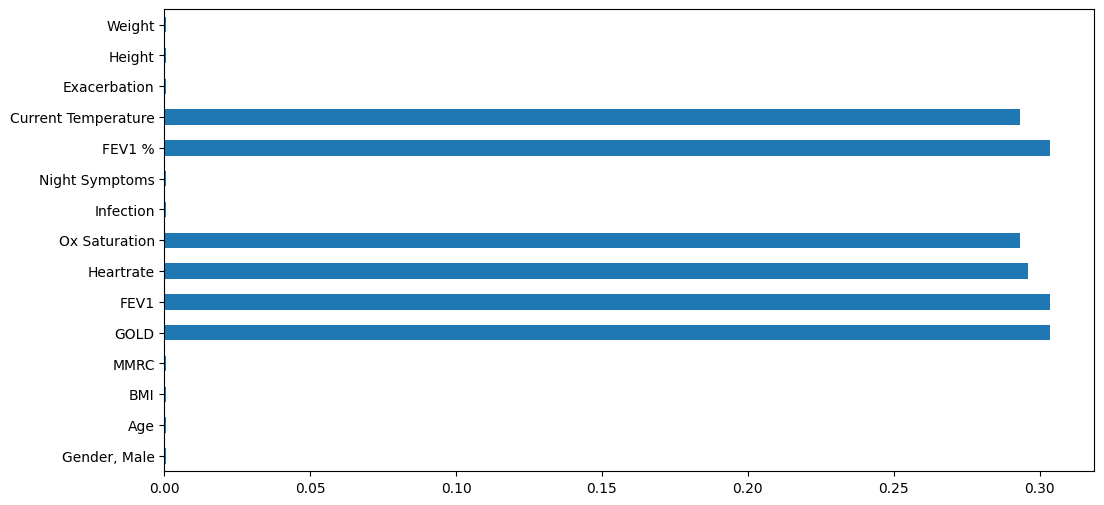

In [8]:
df_triage_mv = df_triage_similars.copy()

# get all variables with missing values
vars_with_na = [var for var in df_triage_mv.columns if df_triage_mv[var].isnull().sum() > 0]
# plot 

# create barplot
df_triage_mv[vars_with_na].isnull().mean().plot.barh(figsize=(12,6))


## Distributions

In [9]:
target = df_triage_similars['Exacerbation']
# create a figure with subplots depending on the number of variables using sqrt
height,width = 7,7
fig, axs = plt.subplots(height, width, figsize=(100, 100))
positives = df_triage_similars[target == 1]
negatives = df_triage_similars[target == 0]
# plot the histogram of each variable
row, col = 0, 0
for var in df_triage_similars.columns:
    # if we are at the end of the row, move to the next row
    if col == width:
        row += 1
        col = 0
    # plot histograms for positives and negatives with 50% opacity, bins should always center around the tick
    sns.histplot(positives[var], ax=axs[row, col], color='orange', label='Exacerbator', alpha=0.5)
    sns.histplot(negatives[var], ax=axs[row, col], color='blue', label='Non-exacerbator', alpha=0.5)
    # create horizontal line at the height of the missing values
    missing_values = df_triage_similars[var].isna().sum()
    axs[row,col].axhline(y=missing_values, color='r', linestyle='-', label='Missing values')
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1


We notice that:
* there are some outliers in the oxygen saturation variable that we can easily deal with
* we probably need a more advanced imputer rather than median or mean so as to not distort the original distributions of GOLD and % FEV1

In [10]:
# will deal with the outliers in the oxygen saturation column by dropping any value under 80%
from sklearn.impute import KNNImputer
df_triage_outliers = df_triage_similars.copy()
df_triage_outliers = df_triage_outliers[df_triage_outliers['Ox Saturation'] >= 80]

# use KNN
df_trial_impuation = df_triage_outliers.copy()
# use KNN imputer to fill in the missing values
imputer = KNNImputer(n_neighbors=5)
df_trial_impuation.iloc[:, :] = imputer.fit_transform(df_trial_impuation)

# bin all values in GOLD between 1 and 2 into 1, between 2 and 3 into 2, between 3 and 4 into 3
df_trial_impuation['Gold'] = df_trial_impuation['Gold'].apply(lambda x: 1 if x < 2 else 2 if x < 3 else 3 if x < 4 else 4)


# plot the distributions of before and after of FEV1 %, Ox Saturation, Heartrate, FEV1 and GOLD
fig, ax = plt.subplots(2, 6, figsize=(20, 10))
sns.histplot(df_triage_outliers['FEV1 %'], ax=ax[0, 0])
sns.histplot(df_triage_outliers['Ox Saturation'], ax=ax[0, 1])
sns.histplot(df_triage_outliers['Heartrate'], ax=ax[0, 2])
sns.histplot(df_triage_outliers['FEV1'], ax=ax[0, 3])
sns.histplot(df_triage_outliers['Gold'], ax=ax[0, 4])


sns.histplot(df_trial_impuation['FEV1 %'], ax=ax[1, 0])
sns.histplot(df_trial_impuation['Ox Saturation'], ax=ax[1, 1])
sns.histplot(df_trial_impuation['Heartrate'], ax=ax[1, 2])
sns.histplot(df_trial_impuation['FEV1'], ax=ax[1, 3])
sns.histplot(df_trial_impuation['Gold'], ax=ax[1, 4])


C:\Users\Daniel\AppData\Local\Temp\ipykernel_21160\3760443324.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_trial_impuation.iloc[:, :] = imputer.fit_transform(df_trial_impuation)


KeyError: 'Gold'

# Classification

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier


target = "Exacerbation"

X = df_triage_outliers.drop(columns=[target], axis=1)
y = df_triage_outliers[target]


stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

xgb_pipeline = Pipeline(steps = [
    ['imputer', SimpleImputer(strategy='median')],
    ['scaler', StandardScaler()],
    ['rf', XGBClassifier()]
])


# k_fold = KFold(n_splits=10, shuffle=True)

# create a list of all the metrics we want to calculate
# scoring = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'AUC': 'roc_auc'}

xgb_param_grid = {
    'rf__n_estimators': [5, 10, 20, 50, 100, 200, 500],
    'rf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'rf__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
}

xgb_grid_search = GridSearchCV(estimator=xgb_pipeline,
                           param_grid=xgb_param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1, verbose=3, return_train_score=True)

xgb_grid_search.fit(X, y)

# print best parameters
print(xgb_grid_search.best_params_)

xgb_cv_score = xgb_grid_search.best_score_
print(xgb_cv_score)


Fitting 5 folds for each of 280 candidates, totalling 1400 fits
{'rf__learning_rate': 0.05, 'rf__max_depth': 3, 'rf__n_estimators': 100}
0.7954061995984107


In [ ]:
# now create variable importance using categories
triage_baseline = df_triage_initial.drop(columns=['Current Heart Rate','Current Pulse Ox', 'Current Temperature', 'Current FEV1 (% Predicted)', 'Current Dyspnea (MMRC)', ], axis=1)

symptoms = ['Wheezing?', 'Cough?', 'Sputum?', 'Short of Breath?', 'Recent Worsening in Symptoms?', 'Infection?', 'Respiratory Symptoms Wake You Up At Night More Than Usual?', 'Acid Reflux', 'Symptom Severity (1-5)']
socio_demographics = ['Height(cm)', 'Age', 'Gender', 'BMI', 'Weight(kg)', 'Lives Alone', 'Needs Help Performing Daily Activities', ]
respiratory_characteristics = ['Baseline FEV1', 'Baseline FEV1 (% Predicted)', 'Baseline Dyspnea (MMRC)',  'Baseline Heart Rate', 'Baseline Pulse Ox']
vital_signs = ['Baseline Heart Rate.1','Baseline Pulse Ox.1',  ]
copd_characteristics = ['COPD Gold Stage', 'Smoker']
medications = ['% Controller Medication Taken Over Last Week','Long Term Oxygen User', 'Pill for Controlling Exacerbations ', ' Prescribed Inhaler ', ' Rescue Inhaler As Needed',  'Prescribed Inhaler (Azithromycin or Roflumilast) ', ' rescue Inhaler As Needed.', 'Rescue Inhaler Or Nebulizer As Needed For Breathing', ]
comorbidities = ['Chronic Kidney Disease', 'Coronary Artery Disease', 'Asthma', 'Diabetes', 'High Blood Pressure', 'Pulmonary Hypertension', 'Congestive Heart Failure', 'Anemia']
history = ['Hospitalized for COPD in Last Year', '2 or More Exacerbations In Last Year','Visited ICU for COPD in Last Year' ]

# remaining = triage_baseline.drop(columns=symptoms+socio_demographics+respiratory_characteristics+vital_signs+copd_characteristics+medication+comorbidities+history, axis=1)
# print(remaining.columns)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
# import lazy predict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# do 100 fold cross validation using LightGBM
X = triage_baseline.drop(columns=['Exacerbation (Y/N)'], axis=1)
y = triage_baseline['Exacerbation (Y/N)']

# # # first get the baseline
clf = LGBMClassifier()
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=8)
# # fit the model
# model, predictions = clf.fit(X_train, X_test, y_train, y_test)
# model


pipeline = make_pipeline(clf)
scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
default_score = np.mean(scores)

variable_classes = {'symptoms': symptoms, 'medication': medication, 'socio_demographics': socio_demographics, 'respiratory_characteristics': respiratory_characteristics, 'copd_characteristics': copd_characteristics, 'history': history, 'vital_signs':vital_signs, 'comorbidities': comorbidities}

importances_means = []
importances_std = []
# now perform leave one class out cross validation
for variable_class, variables in variable_classes.items():
    # remove the variables from the baseline_df
    baseline_df_reduced = triage_baseline.drop(columns=variables)
    # get the X and y
    X_reduced = baseline_df_reduced.drop(columns=['Exacerbation (Y/N)'])
    y_reduced = baseline_df_reduced['Exacerbation (Y/N)']
    # do 5 fold cross validation using LightGBM
    clf = LGBMClassifier()
    scores = cross_val_score(clf, X_reduced, y_reduced, cv=5, scoring='roc_auc', n_jobs=-1)
    score = np.mean(scores)
    score_differences = np.abs(scores - default_score)
    variance = np.std(score_differences)
    print(f'ROC AUC score without {variable_class} is {score}')
    importances_means.append(score - default_score)
    importances_std.append(variance)
# create a horizontal barplot of the importances with the label being the variable class. Add error bars using the standard deviation. 
plt.barh(list(variable_classes.keys()), importances_means, xerr=importances_std)
# set x label is "change compared to using all variables"
plt.xlabel('Change in ROC AUC compared to using all variables')
# y label is "variable category"
plt.ylabel('Variable category')
# then remove one variable class at a time and see how the performance changes

ValueError: Input y contains NaN.